In [23]:
import os

In [24]:
def get_overlapping_simulations(software_dir, momentsLD_dir):
    """
    Find overlapping simulation files between software and momentsLD directories
    
    Args:
        software_dir (str): Path to software inferences directory
        momentsLD_dir (str): Path to momentsLD inferences directory
        
    Returns:
        tuple: Lists of overlapping software and momentsLD files (with full paths)
    """
    # Get list of files in each directory
    momentsLD_files = os.listdir(momentsLD_dir)
    software_files = os.listdir(software_dir)
    
    # Extract numbers from momentsLD files
    momentsLD_numbers = set()
    momentsLD_file_dict = {}  # Store mapping of number to full filename
    
    for file in momentsLD_files:
        if file.startswith('momentsLD_inferences_sim_') and file.endswith('.pkl'):
            try:
                num = int(file.split('_')[-1].split('.')[0])
                momentsLD_numbers.add(num)
                momentsLD_file_dict[num] = file
            except ValueError:
                continue

    # Find matching software files
    overlapping_software_files = []
    overlapping_momentsLD_files = []
    
    for file in software_files:
        if file.startswith('software_inferences_sim_') and file.endswith('.pkl'):
            try:
                num = int(file.split('_')[-1].split('.')[0])
                if num in momentsLD_numbers:
                    # Store full paths
                    overlapping_software_files.append(os.path.join(software_dir, file))
                    overlapping_momentsLD_files.append(os.path.join(momentsLD_dir, momentsLD_file_dict[num]))
            except ValueError:
                continue

    # Sort both lists by simulation number
    sorted_pairs = sorted(zip(overlapping_software_files, overlapping_momentsLD_files), 
                         key=lambda x: int(x[0].split('_')[-1].split('.')[0]))
    
    overlapping_software_files, overlapping_momentsLD_files = zip(*sorted_pairs)
    
    print(f"Found {len(momentsLD_numbers)} momentsLD files")
    print(f"Found {len(overlapping_software_files)} overlapping pairs")
    
    if overlapping_software_files:
        print("\nSample of overlapping simulation numbers:")
        for software_file in list(overlapping_software_files)[:5]:
            num = int(software_file.split('_')[-1].split('.')[0])
            print(f"Simulation {num}")
            
    return list(overlapping_software_files), list(overlapping_momentsLD_files)

# Use the function
software_inferences_dir = "/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir"
momentsLD_inferences_dir = "/sietch_colab/akapoor/Demographic_Inference/final_LD_inferences"

# Get the overlapping files with full paths
software_files, momentsLD_files = get_overlapping_simulations(software_inferences_dir, momentsLD_inferences_dir)

Found 4923 momentsLD files
Found 4923 overlapping pairs

Sample of overlapping simulation numbers:
Simulation 0
Simulation 1
Simulation 2
Simulation 3
Simulation 4


In [25]:
import pandas as pd
import numpy as np
import os
import glob
import pickle
import json
from sklearn.model_selection import train_test_split

experiment_config_file = '/sietch_colab/akapoor/Demographic_Inference/experiment_config.json'
software_inferences_dir = "/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir"
momentsLD_inferences_dir = "/sietch_colab/akapoor/Demographic_Inference/final_LD_inferences"

# Load configuration
with open(experiment_config_file, "r") as f:
    experiment_config = json.load(f)

parameters = ["Na", "N1", "N2", "t_split"]
replicates = experiment_config['top_values_k']

# Containers for predictions and targets
software_predictions_data = []
momentsLD_predictions_data = []
targets_data = []

# Process software inference files
for idx, filepath in enumerate(software_files):
    with open(filepath, 'rb') as f:
        sim_data = pickle.load(f)
    
    row = {}
    
    # Verify dadi and moments predictions
    for replicate in range(1, replicates + 1):
        for param in parameters:
            dadi_val = sim_data['opt_params_dadi'][replicate - 1][param]
            moments_val = sim_data['opt_params_moments'][replicate - 1][param]

            row[f"dadi_rep{replicate}_{param}"] = dadi_val
            row[f"moments_rep{replicate}_{param}"] = moments_val

    software_predictions_data.append(row)
    targets_data.append({f"simulated_params_{param}": sim_data['simulated_params'][param] 
                        for param in parameters})

# Process MomentsLD inference files
for idx, filepath in enumerate(momentsLD_files):
    with open(filepath, 'rb') as f:
        momentsLD_sim_data = pickle.load(f)

    row = {}

    for param in parameters:
        val = momentsLD_sim_data['opt_params_momentsLD'][0][param]
        if np.isnan(val):
            print(f"nan value for {param} in {filepath}")
        row[f"momentsLD_{param}"] = val

    momentsLD_predictions_data.append(row)

# Create DataFrames
software_df = pd.DataFrame(software_predictions_data)
momentsLD_df = pd.DataFrame(momentsLD_predictions_data)
targets_df = pd.DataFrame(targets_data)

# Combine software and momentsLD predictions
combined_predictions_df = pd.concat([software_df, momentsLD_df], axis=1)

# Drop any row that has at least one NaN value
combined_predictions_df = combined_predictions_df.dropna()
valid_indices = combined_predictions_df.dropna().index
combined_predictions_df = combined_predictions_df.loc[valid_indices].reset_index(drop=True)
targets_df = targets_df.loc[valid_indices].reset_index(drop=True)

# Filter based on bounds for all methods and parameters
mask = pd.Series(True, index=combined_predictions_df.index)

# Filter for each parameter and method
methods = ['momentsLD', 'dadi_rep1', 'dadi_rep2', 'moments_rep1', 'moments_rep2']

for param in parameters:
    # Get bounds for this parameter
    lower = experiment_config['lower_bound_params'][param]
    upper = experiment_config['upper_bound_params'][param]
    
    # Add to mask for each method
    for method in methods:
        col_name = f"{method}_{param}"
        param_mask = (combined_predictions_df[col_name] >= lower) & (combined_predictions_df[col_name] <= upper)
        mask &= param_mask

# Apply final mask to both dataframes
combined_predictions_df = combined_predictions_df[mask].reset_index(drop=True)
targets_df = targets_df[mask].reset_index(drop=True)

# Final NaN check
combined_predictions_df = combined_predictions_df.dropna()
valid_indices = combined_predictions_df.dropna().index
combined_predictions_df = combined_predictions_df.loc[valid_indices].reset_index(drop=True)
targets_df = targets_df.loc[valid_indices].reset_index(drop=True)

# Print shapes to verify
print("Final shapes:")
print(f"Predictions shape: {combined_predictions_df.shape}")
print(f"Targets shape: {targets_df.shape}")

Final shapes:
Predictions shape: (3826, 20)
Targets shape: (3826, 4)


In [26]:
# Generate train/validation split indices
train_indices, val_indices = train_test_split(
    range(len(combined_predictions_df)), 
    test_size=0.2, 
    random_state=42
)

# Create the preprocessing results object
preprocessing_results_obj = {
    "training": {
        "predictions": combined_predictions_df.iloc[train_indices].reset_index(drop=True),
        "targets": targets_df.iloc[train_indices].reset_index(drop=True),
        "indices": train_indices,
    },
    "validation": {
        "predictions": combined_predictions_df.iloc[val_indices].reset_index(drop=True),
        "targets": targets_df.iloc[val_indices].reset_index(drop=True),
        "indices": val_indices,
    },
    "parameter_names": parameters
}

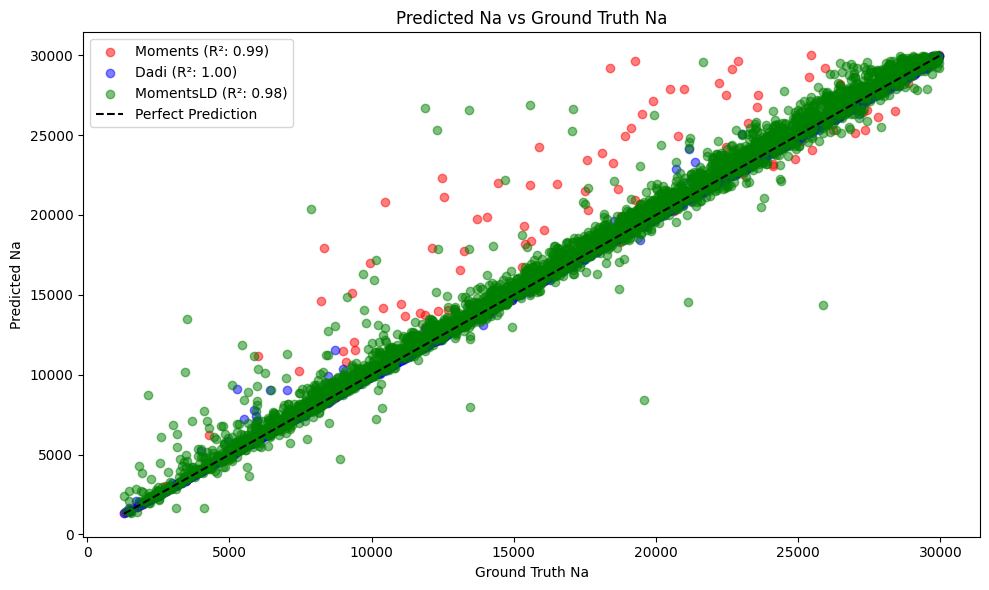

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Extract just the Na predictions and ground truth
ground_truth_Na = preprocessing_results_obj['training']['targets']['simulated_params_Na']
predictions = preprocessing_results_obj['training']['predictions']

# Plot with just one point per simulation first
plt.figure(figsize=(10, 6))

# Plot moments first replicate
moments_rep1 = predictions['moments_rep1_Na']
r2_moments = np.corrcoef(ground_truth_Na, moments_rep1)[0, 1] ** 2
plt.scatter(ground_truth_Na, moments_rep1, color='red', alpha=0.5, 
            label=f'Moments (R²: {r2_moments:.2f})')

# Plot dadi first replicate
dadi_rep1 = predictions['dadi_rep1_Na']
r2_dadi = np.corrcoef(ground_truth_Na, dadi_rep1)[0, 1] ** 2
plt.scatter(ground_truth_Na, dadi_rep1, color='blue', alpha=0.5, 
            label=f'Dadi (R²: {r2_dadi:.2f})')

# Plot MomentsLD
momentsLD_Na = predictions['momentsLD_Na']
r2_momentsLD = np.corrcoef(ground_truth_Na, momentsLD_Na)[0, 1] ** 2
plt.scatter(ground_truth_Na, momentsLD_Na, color='green', alpha=0.5, 
            label=f'MomentsLD (R²: {r2_momentsLD:.2f})')

# Perfect prediction line
plt.plot([ground_truth_Na.min(), ground_truth_Na.max()],
         [ground_truth_Na.min(), ground_truth_Na.max()],
         color='black', linestyle='--', label='Perfect Prediction')

plt.xlabel('Ground Truth Na')
plt.ylabel('Predicted Na')
plt.title('Predicted Na vs Ground Truth Na')
plt.legend()
plt.tight_layout()
plt.show()
